# Predicting Local Satisfaction in England
**Multivariate regression analysis of UK social wellbeing indicators**  

**Notebook contents:**  
- Executive summary (non-technical)  
- Findings with visuals (for stakeholders)  
- Statistical methodology, model building and diagnostics (for data scientists)  
- Appendix: annotated R code and region-wise models


In [41]:
# Load libraries
library(ggplot2)
library(data.table)
library(readr)
library(tidyverse)
library(broom)
library(knitr)
library(kableExtra)
library(car)          
library(ggpubr)       

# For reproducibility
set.seed(123)


### Executive Summary

This project applies multiple linear regression to identify factors influencing residents’ satisfaction across England. Using national wellbeing data, the analysis links perceptions of community cohesion, belonging, and local issues to overall satisfaction.

Key insights:

- Community cohesion (GetOnWell) and belonging (Belong) strongly increase satisfaction.

- Perceived drug problems (DrugUse) significantly reduce satisfaction across most regions.

- Influence plays a smaller, region-specific role.

- Regional variation suggests that tailored, area-focused policies are most effective.

Policy takeaway:
Enhancing community bonds and addressing drug-related concerns can meaningfully improve public satisfaction.

## Data Loading and Initial Checks

This section loads the data, inspects basic structure, renames columns for convenience, and checks for missing values.


In [ ]:
# Load data
data <- read_csv("data/UKContentment.csv")

# Show top rows and structure
glimpse(data)


Rows: 352 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Authority, Area
dbl (5): Influence_Decisions, Get_On_Well, Belong, Drug_Use_And_Selling, Ove...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 352
Columns: 7
$ Authority            <chr> "City of London LB", "Barking and Dagenham LB", "…
$ Influence_Decisions  <dbl> 41.8, 37.0, 37.3, 26.4, 40.0, 26.8, 36.1, 33.8, 3…
$ Get_On_Well          <dbl> 91.6, 49.1, 83.4, 69.2, 76.8, 81.2, 81.7, 76.6, 7…
$ Belong               <dbl> 58.7, 44.8, 56.8, 54.5, 48.9, 57.4, 51.9, 51.1, 4…
$ Drug_Use_And_Selling <dbl> 11.7, 52.1, 26.5, 30.3, 44.1, 22.9, 45.0, 33.2, 3…
$ Area                 <chr> "London", "London", "London", "London", "London",…
$ Overall              <dbl> 92.4, 56.6, 79.5, 73.9, 68.3, 83.8, 81.7, 71.3, 6…


In [43]:
head(data)

Authority,Influence_Decisions,Get_On_Well,Belong,Drug_Use_And_Selling,Area,Overall
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
City of London LB,41.8,91.6,58.7,11.7,London,92.4
Barking and Dagenham LB,37.0,49.1,44.8,52.1,London,56.6
Barnet LB,37.3,83.4,56.8,26.5,London,79.5
Bexley LB,26.4,69.2,54.5,30.3,London,73.9
Brent LB,40.0,76.8,48.9,44.1,London,68.3
Bromley LB,26.8,81.2,57.4,22.9,London,83.8


In [44]:
summary(data)

  Authority         Influence_Decisions  Get_On_Well        Belong     
 Length:352         Min.   :19.80       Min.   :49.10   Min.   :42.80  
 Class :character   1st Qu.:26.07       1st Qu.:74.00   1st Qu.:55.30  
 Mode  :character   Median :28.20       Median :78.40   Median :59.80  
                    Mean   :28.68       Mean   :77.18   Mean   :59.66  
                    3rd Qu.:30.80       3rd Qu.:81.62   3rd Qu.:63.70  
                    Max.   :45.70       Max.   :91.60   Max.   :75.10  
 Drug_Use_And_Selling     Area              Overall     
 Min.   :10.30        Length:352         Min.   :56.00  
 1st Qu.:21.88        Class :character   1st Qu.:76.50  
 Median :26.80        Mode  :character   Median :82.95  
 Mean   :28.33                           Mean   :81.24  
 3rd Qu.:33.33                           3rd Qu.:86.42  
 Max.   :60.70                           Max.   :94.20  

In [45]:
# Rename columns to friendly names (keeps content semantics)
colnames(data) <- c("Authority", "Influence", "GetOnWell", "Belong", "DrugUse", "Area", "Overallpoint")

# Confirm rename
colnames(data)


[1] "Authority"    "Influence"    "GetOnWell"    "Belong"       "DrugUse"     
[6] "Area"         "Overallpoint"

In [46]:
# Missing values check
total_missing <- sum(is.na(data))
total_missing  # print total missing count


[1] 0

## Descriptive Statistics & Pairwise Relationships

We examine distributions, pairwise scatter relationships, and the correlation matrix for the primary numerical variables.


In [47]:
smart_kable <- function(df, caption = NULL, digits = 2) {
  # Detect environment type
  if (isTRUE(knitr::is_latex_output()) || isTRUE(knitr::is_html_output())) {
    # In RMarkdown / Notebook rendering mode
    df %>%
      kable(caption = caption, digits = digits) %>%
      kable_styling(full_width = FALSE)
    
  } else if (interactive()) {
    # In RStudio console or interactive session
    # Option 1: try rendering in Viewer with gt
    df %>%
      gt() %>%
      tab_header(title = caption)
    
  } else {
    # Fallback to plain text for basic console output
    kable(df, caption = caption, digits = digits, format = "simple")
  }
}

In [48]:
desc_table <- data %>%
  select(Influence, GetOnWell, Belong, DrugUse, Overallpoint) %>%
  summarise(across(
    everything(),
    list(mean = mean, sd = sd, min = min, max = max, median = median),
    .names = "{.col}---{.fn}"
  )) %>%
  pivot_longer(
    everything(),
    names_to = c("variable", ".value"),
    names_sep = "---"
  )

smart_kable(desc_table, caption = "Descriptive statistics for main variables")



Table: Descriptive statistics for main variables

variable         mean     sd    min    max   median
-------------  ------  -----  -----  -----  -------
Influence       28.68   3.95   19.8   45.7    28.20
GetOnWell       77.18   6.65   49.1   91.6    78.40
Belong          59.66   6.20   42.8   75.1    59.80
DrugUse         28.33   9.16   10.3   60.7    26.80
Overallpoint    81.24   7.08   56.0   94.2    82.95

#### Interpretation
The table above summarizes the central tendency and spread of the key variables.  
On average, residents report **moderately high satisfaction** (`Overallpoint ≈ 81`) and **strong community cohesion** (`GetOnWell ≈ 77`).  
Perceptions of **drug use** show the greatest variability across areas, while **influence** scores are relatively low and stable.  
These descriptive patterns suggest that social harmony and perceived safety may play an important role in shaping overall satisfaction.

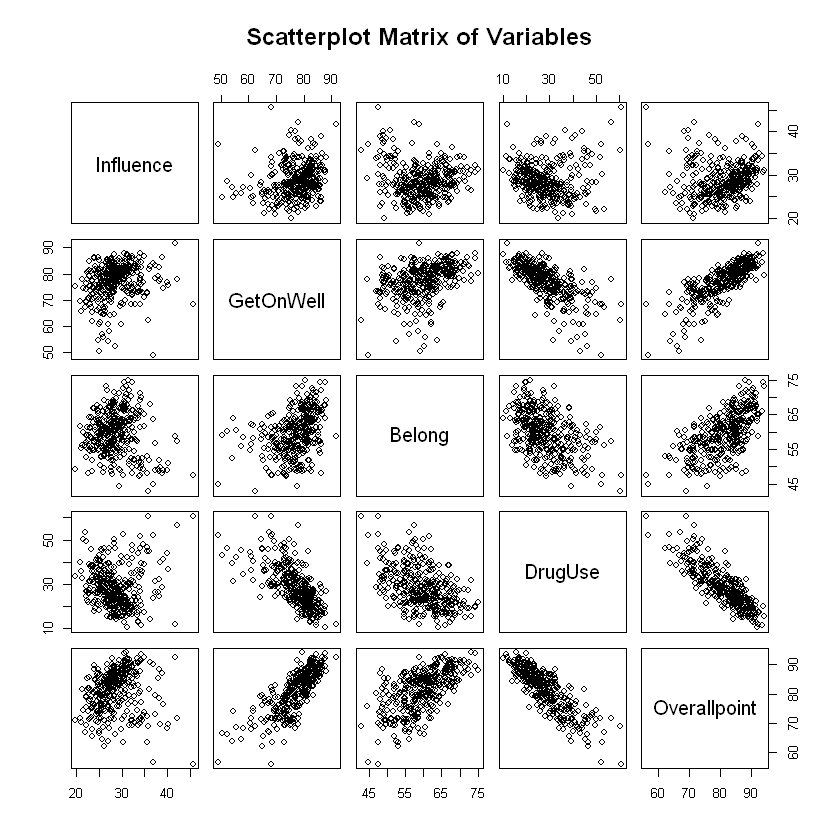

In [49]:
# Pairwise scatterplot matrix (traditional)
pairs(data[c("Influence", "GetOnWell", "Belong", "DrugUse", "Overallpoint")],
      main = "Scatterplot Matrix of Variables")


In [50]:
# Correlation matrix (visual)
corr_df <- round(cor(data %>% select(Influence, GetOnWell, Belong, DrugUse, Overallpoint)), 3)
corr_df

,Influence,GetOnWell,Belong,DrugUse,Overallpoint
Influence,1.000,0.199,-0.091,-0.026,0.102
GetOnWell,0.199,1.000,0.371,-0.689,0.787
Belong,-0.091,0.371,1.000,-0.476,0.620
DrugUse,-0.026,-0.689,-0.476,1.000,-0.846
Overallpoint,0.102,0.787,0.620,-0.846,1.000


### Interpretation (descriptive)
- `GetOnWell` and `Belong` appear positively correlated with `Overallpoint`.  
- `DrugUse` shows a negative correlation with `Overallpoint` in the aggregate.  
- These patterns motivate the multivariate regression to quantify effects while adjusting for the other predictors.


## Multiple Linear Regression (Model 1: Nationwide)

We fit a multivariate linear regression:
`Overallpoint ~ Influence + GetOnWell + Belong + DrugUse`

We will inspect coefficients, p-values, R-squared, and perform model diagnostics.


In [51]:
# Fit Model 1
model1 <- lm(Overallpoint ~ Influence + GetOnWell + Belong + DrugUse, data = data)
# Classic summary
summary(model1)


Call:
lm(formula = Overallpoint ~ Influence + GetOnWell + Belong + 
    DrugUse, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.9013 -1.6873  0.0456  1.6870  9.7686 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 42.34256    3.35834  12.608   <2e-16 ***
Influence    0.07945    0.03901   2.036   0.0425 *  
GetOnWell    0.37324    0.03182  11.731   <2e-16 ***
Belong       0.30559    0.02739  11.157   <2e-16 ***
DrugUse     -0.36784    0.02365 -15.553   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.764 on 347 degrees of freedom
Multiple R-squared:  0.8492,	Adjusted R-squared:  0.8475 
F-statistic: 488.5 on 4 and 347 DF,  p-value: < 2.2e-16


In [52]:
# Tidy results and formatted table
model1_tidy <- tidy(model1) %>%
  mutate(
    estimate = round(estimate, 4),
    std.error = round(std.error, 4),
    statistic = round(statistic, 3),
    p.value = round(p.value, 4)
  )

smart_kable(model1_tidy, caption = "Model 1: Coefficients and test statistics")




Table: Model 1: Coefficients and test statistics

term           estimate   std.error   statistic   p.value
------------  ---------  ----------  ----------  --------
(Intercept)       42.34        3.36       12.61      0.00
Influence          0.08        0.04        2.04      0.04
GetOnWell          0.37        0.03       11.73      0.00
Belong             0.31        0.03       11.16      0.00
DrugUse           -0.37        0.02      -15.55      0.00

### Interpretation (Model 1)
- Coefficients indicate the estimated change in `Overallpoint` per unit change in each predictor, holding others constant.  
- `GetOnWell` and `Belong` have the largest positive coefficients, while `DrugUse` has a negative coefficient.  
- We will verify assumptions using diagnostic plots and additional checks (VIF for multicollinearity).


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


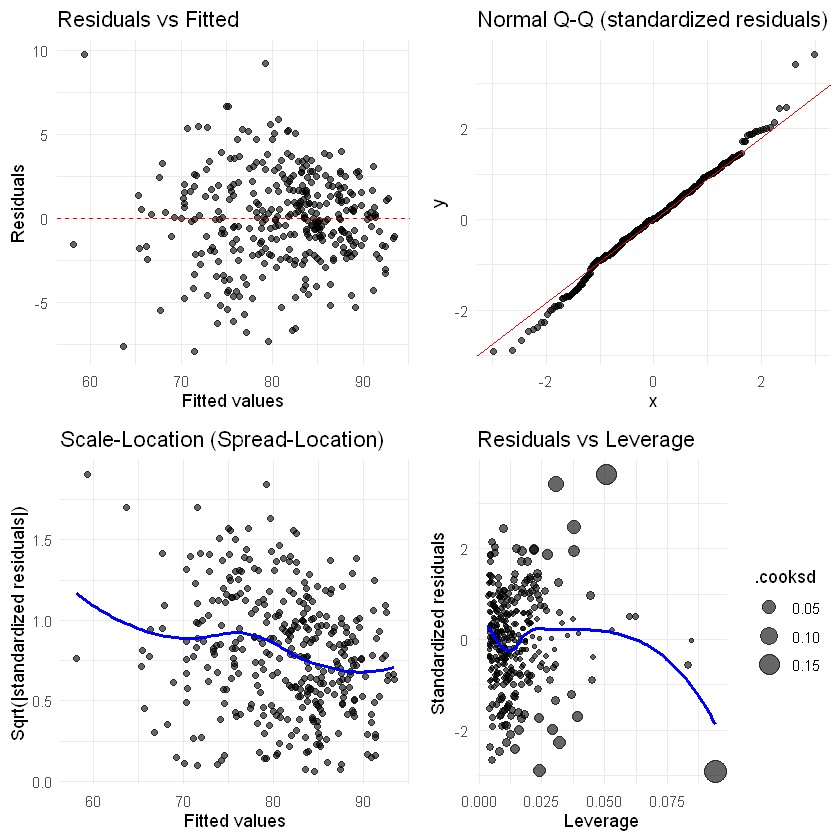

In [53]:
# Use broom::augment to get residuals & fitted
aug1 <- augment(model1)

# Residuals vs Fitted (ggplot)
p1 <- ggplot(aug1, aes(.fitted, .resid)) +
  geom_point(alpha = 0.6) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Residuals vs Fitted", x = "Fitted values", y = "Residuals") +
  theme_minimal()

# Normal Q-Q (ggplot)
p2 <- ggplot(aug1, aes(sample = .std.resid)) +
  stat_qq(alpha = 0.6) +
  stat_qq_line(color = "red") +
  labs(title = "Normal Q-Q (standardized residuals)") +
  theme_minimal()

# Scale-Location (sqrt of standardized residuals vs fitted)
p3 <- ggplot(aug1, aes(.fitted, sqrt(abs(.std.resid)))) +
  geom_point(alpha = 0.6) +
  geom_smooth(se = FALSE, method = "loess", color = "blue") +
  labs(title = "Scale-Location (Spread-Location)", x = "Fitted values", y = "Sqrt(|standardized residuals|)") +
  theme_minimal()

# Residuals vs Leverage
p4 <- ggplot(aug1, aes(.hat, .std.resid)) +
  geom_point(aes(size = .cooksd), alpha = 0.6) +
  geom_smooth(se = FALSE, method = "loess", color = "blue") +
  labs(title = "Residuals vs Leverage", x = "Leverage", y = "Standardized residuals") +
  theme_minimal()

# Arrange plots
ggarrange(p1, p2, p3, p4, ncol = 2, nrow = 2)


## Multicollinearity Check and Model Fit

We calculate Variance Inflation Factors (VIF) to check for multicollinearity, and report R-squared / Adjusted R-squared values.


In [54]:
# VIF
vif_vals <- vif(model1)
vif_vals


Influence GetOnWell    Belong   DrugUse 
 1.088852  2.053438  1.324505  2.156892

In [55]:
# R-squared
glance_vals <- glance(model1)
fit_stats <- data.frame(
  R_squared = round(glance_vals$r.squared, 4),
  Adj_R_squared = round(glance_vals$adj.r.squared, 4),
  F_stat = round(glance_vals$statistic, 2),
  F_p_value = signif(glance_vals$p.value, 3)
)

smart_kable(fit_stats, caption = "Model 1: Fit statistics")



Table: Model 1: Fit statistics

         R_squared   Adj_R_squared   F_stat   F_p_value
------  ----------  --------------  -------  ----------
value         0.85            0.85   488.55           0

### Diagnostics Interpretation
- **Residuals vs Fitted**: Random scatter near zero indicates acceptable homoscedasticity.  
- **Normal Q-Q**: Close alignment suggests approximate normality of residuals.  
- **Scale-Location**: No apparent pattern -> homoscedasticity likely acceptable.  
- **Residuals vs Leverage**: No very influential points (though check Cook's distance if needed).  
- **VIF**: Values < 5 (or <10 depending on threshold) -> multicollinearity not a severe issue.  
- **R-squared**: High R^2 indicates good explanatory power on observed data; interpret cautiously.


## Regional Models (Model 2): Fitting the same model by Area

We fit the same linear model separately for each region in `Area` to understand geographic heterogeneity in the effects of predictors on `Overallpoint`.


In [56]:
# Regional analysis function: returns lm object (not summary) for flexibility
regional_analysis_model <- function(region_name) {
  subset_data <- data %>% filter(Area == region_name)
  # Only run model if there are sufficient observations
  if(nrow(subset_data) < 10) {
    return(NULL)
  }
  model <- lm(Overallpoint ~ Influence + GetOnWell + Belong + DrugUse, data = subset_data)
  return(model)
}

# Get area names
areas <- unique(data$Area)

# Fit models and collect tidy coefficients
regional_models <- lapply(areas, regional_analysis_model)
names(regional_models) <- areas

# Create a dataframe of coefficients (include area)
regional_coefficients <- bind_rows(lapply(names(regional_models), function(a) {
  mod <- regional_models[[a]]
  if(is.null(mod)) return(NULL)
  tidy(mod) %>% mutate(Area = a)
}), .id = NULL)

# Keep only the main terms (and intercept optionally)
regional_coefficients <- regional_coefficients %>% 
  mutate(term = as.character(term)) 
head(regional_coefficients)


term,estimate,std.error,statistic,p.value,Area
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),46.6877177,17.0791058,2.7336161,0.0107345661,London
Influence,-0.1067935,0.2139796,-0.4990829,0.6216197496,London
GetOnWell,0.6569830,0.1740993,3.7736118,0.0007684320,London
Belong,-0.1174063,0.2450392,-0.4791326,0.6355651713,London
DrugUse,-0.3242499,0.1106528,-2.9303372,0.0066689653,London
(Intercept),35.1130981,8.2069146,4.2784774,0.0001327264,North West


### Visualising regional coefficients

We plot the regression coefficients for the four predictors across regions to show how effects vary geographically.


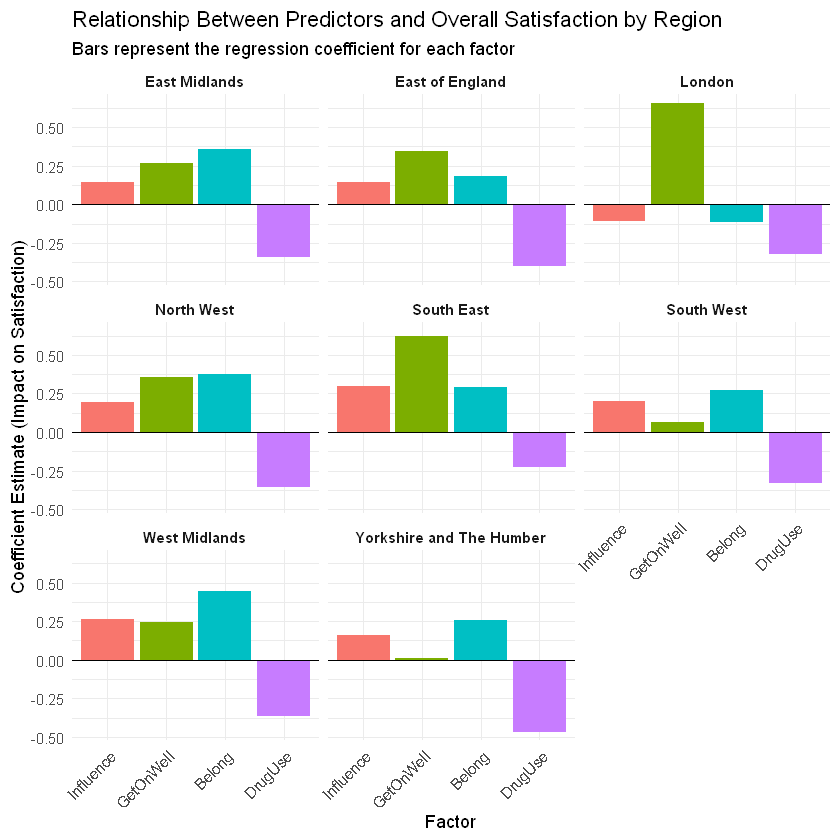

In [57]:
# Filter out intercept
regional_coefficients_no_intercept <- regional_coefficients %>% filter(term != "(Intercept)")

# Factor term ordering for nice x-axis
regional_coefficients_no_intercept$term <- factor(regional_coefficients_no_intercept$term, levels = c("Influence", "GetOnWell", "Belong", "DrugUse"))


regional_faceted_plot <- ggplot(regional_coefficients_no_intercept, aes(x = term, y = estimate, fill = term)) +
  # Use geom_col for a bar chart where height is the 'estimate' value
  geom_col() +
  
  # Add a horizontal line at y=0 to clearly separate positive and negative effects
  geom_hline(yintercept = 0, color = "black", linetype = "solid") +
  
  # Create a grid of plots, with one panel for each 'Area'
  facet_wrap(~ Area, ncol = 3) +
  
  # Add informative labels and a title
  labs(
    title = "Relationship Between Predictors and Overall Satisfaction by Region",
    subtitle = "Bars represent the regression coefficient for each factor",
    x = "Factor",
    y = "Coefficient Estimate (Impact on Satisfaction)"
  ) +
  
  # Use a clean theme and adjust text for readability
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1), # Rotate x-axis labels
    legend.position = "none",                          # Hide legend as colors are redundant
    strip.text = element_text(face = "bold")           # Make region titles bold
  )

# Display the plot
print(regional_faceted_plot)



### Interpretation: Regional Patterns

Across England, the drivers of resident satisfaction vary notably by region.  
**Community Cohesion (`GetOnWell`)** consistently predicts higher satisfaction - especially in **London**, where its impact is strongest.  
**Perceived Drug Use (`DrugUse`)** shows a strong negative effect almost everywhere, highlighting a common social concern.  
In **London**, however, both **`Influence`** and **`Belong`** are slightly negative, suggesting that community harmony outweighs other factors in shaping satisfaction.


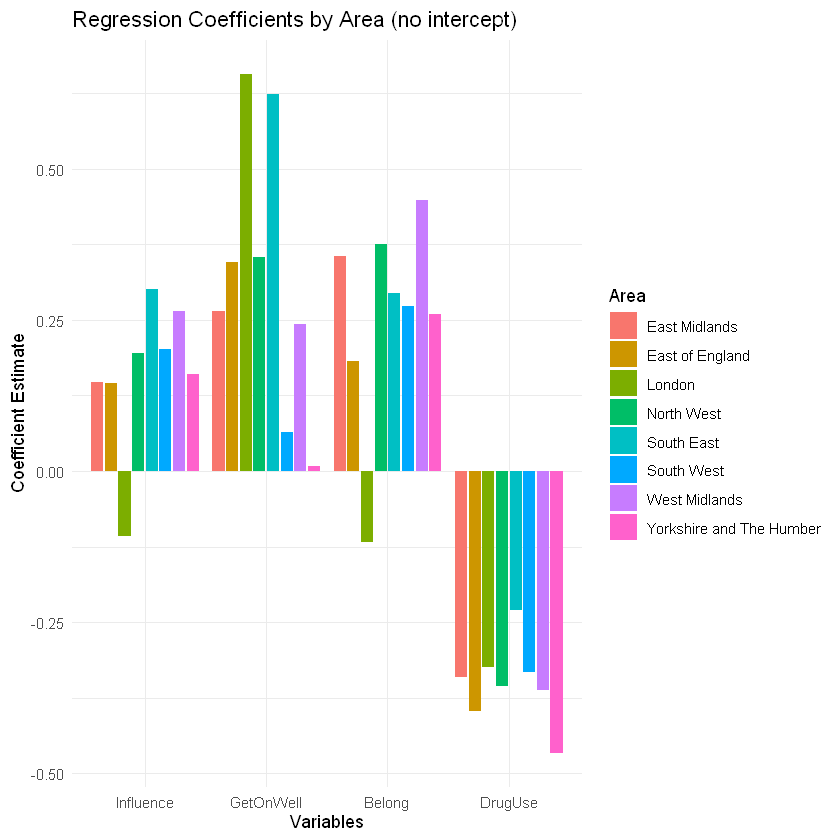

In [58]:
# Plot: coefficient bars grouped by term with area color (narrowly arranged)
plot_difference2 <- ggplot(regional_coefficients_no_intercept, aes(x = term, y = estimate, fill = Area)) +
  geom_col(position = position_dodge(width = 0.9), width = 0.8) +
  labs(title = "Regression Coefficients by Area (no intercept)", x = "Variables", y = "Coefficient Estimate") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 0, hjust = 0.5), legend.position = "right")

plot_difference2

### Interpretation: Factor Comparison Across Regions

This view compares how each factor’s effect differs between regions.  
**`GetOnWell`** has the largest positive coefficient in **London**, while **`DrugUse`** shows the steepest negative effect in **Yorkshire and The Humber**.  
Although this plot highlights contrasts for individual factors, it’s less intuitive for seeing how multiple factors interact within the same region.

In [59]:
for(region in c("London", "North East")) {
  if(!is.null(regional_models[[region]])) {
    cat("\n\n-------Region:", region, "-------\n")
    print(summary(regional_models[[region]]))
  } else {
    cat("\nNo model (or too few observations) for region:", region, "\n")
  }
}




-------Region: London -------

Call:
lm(formula = Overallpoint ~ Influence + GetOnWell + Belong + 
    DrugUse, data = subset_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.9562 -4.5317  0.5505  3.1444  9.8055 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  46.6877    17.0791   2.734 0.010735 *  
Influence    -0.1068     0.2140  -0.499 0.621620    
GetOnWell     0.6570     0.1741   3.774 0.000768 ***
Belong       -0.1174     0.2450  -0.479 0.635565    
DrugUse      -0.3242     0.1107  -2.930 0.006669 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.647 on 28 degrees of freedom
Multiple R-squared:  0.7647,	Adjusted R-squared:  0.7311 
F-statistic: 22.75 on 4 and 28 DF,  p-value: 1.864e-08


No model (or too few observations) for region: North East 


## Limitations & Considerations

- **Causality:** This analysis is observational and identifies associations, not causal effects.  
- **Data granularity:** The data are percentages of “yes” responses - binary to aggregate transformation loses nuance.  
- **Omitted variables:** Important predictors (economic indicators, housing, demographics) are not included.  
- **Region sample sizes:** Some regions may have limited observations; be cautious interpreting those region-specific models.
